# 11. Classification

In the previous chapter we have learned about logistic regression, an ideal first example for classification algorithms given its proximity with standard regression. In this chapter we present a few additional algorithms, and like for regression, show that these methods can also be used with multiple variables.

## Multiple variables

First we check that logistic regression can be used with more than one variable. To demonstrate this, we use here again the seeds dataset, which provides ideal classes examples:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

seeds = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                    sep='\t', on_bad_lines='skip', names=['area', 'perimeter', 'compactness', 'length', 'width', 'symmetry_coef', 'length_groove', 'seed_type']
)

For the moment we keep only a sub-group composed of types ```2``` and ```3```:

In [2]:
seeds_subsel = seeds[(seeds.seed_type == 2) | (seeds.seed_type == 3)]

As done in the previous chapter, we can plot a single variable or **feature** like ```length_groove``` and use logistic regression on it:

In [3]:
from sklearn import linear_model

X = seeds_subsel[['length_groove']]
y = seeds_subsel['seed_type']

log_model = linear_model.LogisticRegression()
log_model.fit(X=X, y=y)

X_pred = pd.DataFrame(np.arange(4.5, 7, 0.1), columns=['length_groove'])
pred_prob = log_model.predict_proba(X_pred)
pred = log_model.predict(X_pred)

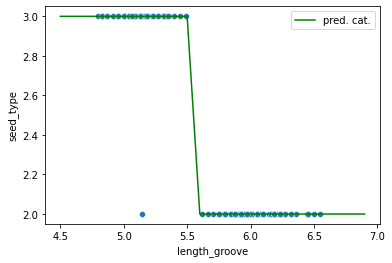

In [4]:
ax = sns.scatterplot(data=seeds_subsel, x='length_groove', y='seed_type');
ax.plot(np.arange(4.5, 7, 0.1), pred, 'g', label='pred. cat.')
ax.legend();

However we can also use multiple features for classification. Just like in linear regression, using more information we have in our data allows for better modeling, i.e. in this case having less miss-classified cases. We can for example look that the ```length_groove``` **and** ```perimeter``` variables.

We can represent such data in two ways. Fist we can plot points in 3D with ```x``` and ```y``` axis representing our features and ```z``` the category (plot below, left). Or we can look at that plot from the top and colour each category (plot below, right):

In [5]:
import matplotlib

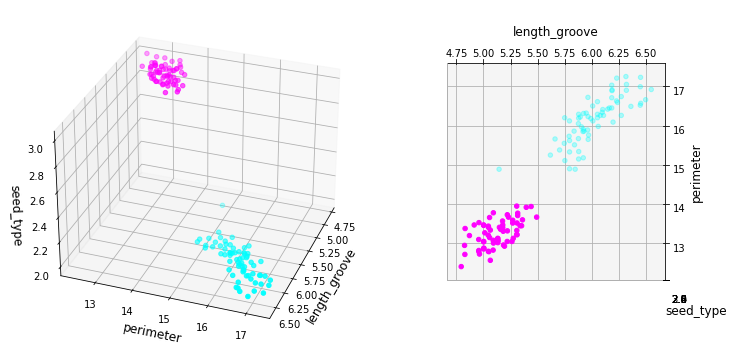

In [6]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axes = [ax1, ax2]
for ax in axes:
    scatter = ax.scatter(seeds_subsel['length_groove'].values,
                     seeds_subsel['perimeter'].values,
                     seeds_subsel['seed_type'].values,
                     c=seeds_subsel['seed_type'].values, cmap='cool'
                        )
                        

    ax.set_xlabel('length_groove', fontdict={'fontsize':12})
    ax.set_ylabel('perimeter', fontdict={'fontsize':12});
    ax.set_zlabel('seed_type', fontdict={'fontsize':12});

ax1.view_init(elev=30., azim=20)
ax2.view_init(elev=90., azim=-90)
ax2.set_proj_type('ortho')
fig.tight_layout()

To separate the categories, we proceed as usual: we define ```X``` with two features and ```y``` as the ```seed_type``` and fit the sklearn model as usual. Note that here again, when we do the prediction we can either predict the category with ```predict``` or the probability with ```predict_proba```:

In [7]:
X = seeds_subsel[['length_groove', 'perimeter']]
y = seeds_subsel['seed_type']

log_model = linear_model.LogisticRegression()
log_model.fit(X=X, y=y)

X_1_grid, X_2_grid = np.meshgrid(
    np.linspace(seeds_subsel.length_groove.min(), seeds_subsel.length_groove.max(), 1000),
    np.linspace(seeds_subsel.perimeter.min(), seeds_subsel.perimeter.max(),1000)
)

# do predictions
pred = log_model.predict(pd.DataFrame({'length_groove': X_1_grid.ravel(), 'perimeter': X_2_grid.ravel()}))
pred_prob = log_model.predict_proba(pd.DataFrame({'length_groove': X_1_grid.ravel(), 'perimeter': X_2_grid.ravel()}))

# select points around decision boundary
sel_line = pred_prob[:,1].copy()
sel_X_1 = X_1_grid.ravel()
sel_X_2 = X_2_grid.ravel()
sel_X_1 = sel_X_1[(sel_line<=0.51) & (sel_line>=0.49)]
sel_X_2 = sel_X_2[(sel_line<=0.51) & (sel_line>=0.49)]
sel_line = sel_line[(sel_line<=0.51) & (sel_line>=0.49)]+2


Instead of separating categories with a step function at a given **point**, we do it with a **surface step function** along a given line (yellow):

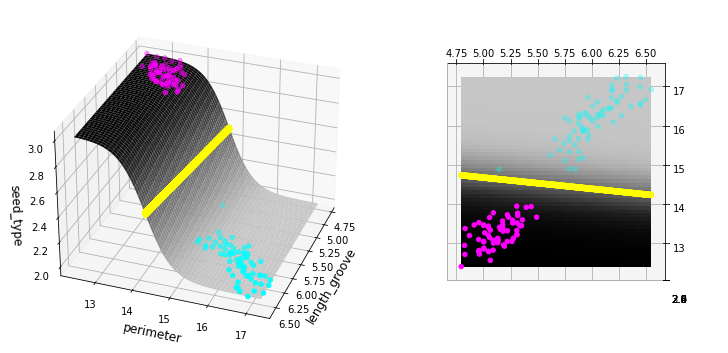

In [8]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d', computed_zorder=False)
ax2 = fig.add_subplot(1, 2, 2, projection='3d', computed_zorder=False)

axes = [ax1, ax2]
for ax in axes:
    surf = ax.plot_surface(X_1_grid, X_2_grid, 2+pred_prob[:,1].reshape(X_1_grid.shape),
                           cmap='Greys', antialiased=True, vmin=1.5, vmax=3)

    scatter = ax.scatter(seeds_subsel['length_groove'].values,
                     seeds_subsel['perimeter'].values,
                     seeds_subsel['seed_type'].values,
                     c=seeds_subsel['seed_type'].values, cmap='cool')
    
    scatter = ax.scatter(sel_X_1, sel_X_2, sel_line, c='Yellow')

    ax1.set_xlabel('length_groove', fontdict={'fontsize':12})
    ax1.set_ylabel('perimeter', fontdict={'fontsize':12});
    ax1.set_zlabel('seed_type', fontdict={'fontsize':12});
ax1.view_init(elev=30., azim=20)
ax2.view_init(elev=90., azim=-90)
ax2.set_proj_type('ortho')
fig.tight_layout()

In the plot above we see that when looking at the surface sigmoid from the top, the boundary becomes just a line!

## Support Vector Machines

In the case of logistic regression, the optimization of the model is made based on a statistical model which is the "happiest" when data are far away from the boundary between classes. In the case of Support Vector Machines (SVC), we try to maximize the **margin** between two classes. In other words, as long as points are classified correctly we only care about points which are very close to the boundary and somehow define it.

Let's have a looks at the example above and try the SVM model which is found in the ```svm``` module:

In [9]:
from sklearn import svm

Here again, we define our ```X``` and ```y``` variable, create our model and call the ```fit``` function. The ```C``` parameter controls how much we are sensitive to outliers (see next section):


In [10]:
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y);

As before we can find the category of a given point using the ```predict``` method. Additionally we can now recover information about how far a given point is form the separation "hyper-plane":

In [11]:
print(f'top right corner: {clf.predict([[6.2, 16]])}')
print(f'distance top right corner: {clf.decision_function([[6.2, 16]])}')

print(f'bottom left corner: {clf.predict([[5, 14]])}')
print(f'distacne bottom left corner: {clf.decision_function([[5, 14]])}')


top right corner: [2]
distance top right corner: [-3.36110337]
bottom left corner: [3]
distacne bottom left corner: [0.8933631]


/Users/gw18g940/mambaforge/envs/EHML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


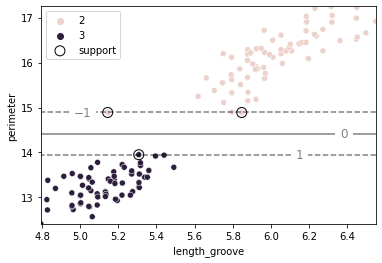

In [12]:
ax = sns.scatterplot(data=seeds_subsel, x='length_groove', y='perimeter', hue='seed_type')

xx = np.linspace(seeds_subsel.length_groove.min(), seeds_subsel.length_groove.max(), 1000)
yy = np.linspace(seeds_subsel.perimeter.min(), seeds_subsel.perimeter.max(),1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    X_1_grid, X_2_grid, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

In the above plot, we see the decision boundary (continuous line): depending on which side of that line a seed is, it is either of type 2 or 3. In addition we see dotted lines representing the "margin" of the model and the specific points (circled) that are used to define it. The idea of maximizing the margin is that this gives the best chance for a new point to be classified correctly.

## Outliers and regularization

We see above that we have an outlier point of type 2 on the left of the plot. Let's see what happens if we just manually remove this point:

In [13]:
X_clean = X[X.length_groove>5.2]
y_clean = y[X.length_groove>5.2]

clf_clean = svm.SVC(kernel="linear", C=1000)
clf_clean.fit(X_clean, y_clean);

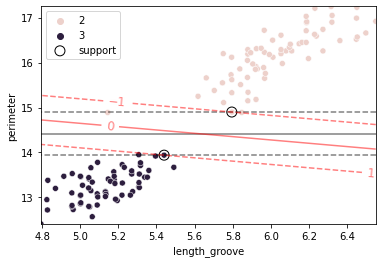

In [14]:
ax = sns.scatterplot(data=seeds_subsel, x='length_groove', y='perimeter', hue='seed_type')

Z_clean = clf_clean.decision_function(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    X_1_grid, X_2_grid, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
CS = ax.contour(
    X_1_grid, X_2_grid, Z_clean, colors="r", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(clf_clean.support_vectors_[:, 0], clf_clean.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

We see that now the classifier (red) slightly tilted as it is no more "forced" to consider the most extreme cases.

One doesn't actually have to remove points manually, but we can adjust the **regularization** of the method. If ```C``` is high, it means we have little regularization, i.e. we force the method to try to do a "perfect" classification, even at the cost of creating a boundary which might not be optimal as above. If we use a lower ```C```, the regularization increases, and so we favor using more points (more support vectors) to define the boundary, but we also have to accept that some points are miss-classified. Let's see what happens with a much lower ```C```:

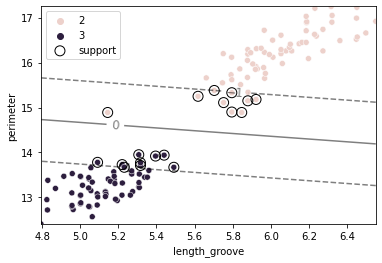

In [15]:
clf_lowC = svm.SVC(kernel="linear", C=0.1)
clf_lowC.fit(X, y);

ax = sns.scatterplot(data=seeds_subsel, x='length_groove', y='perimeter', hue='seed_type')

xx = np.linspace(seeds_subsel.length_groove.min(), seeds_subsel.length_groove.max(), 1000)
yy = np.linspace(seeds_subsel.perimeter.min(), seeds_subsel.perimeter.max(),1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_lowC.decision_function(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    X_1_grid, X_2_grid, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(clf_lowC.support_vectors_[:, 0], clf_lowC.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

We see that the point that was previously skewing our decision is now still properly classified but very close to the decision boundary. With regularization, our model is capable of taking into account that some points are outliers and that we shouldn't care too much about them!

## No perfect boundary

In the example above, even though we have a point which is far from the norm, it is still possible to find a boundary to properly classify it, and even if we agree to "ignore" it, it gets classified properly. There are however cases where **there is no way to trace a hyper-plane** that properly classifies **all** points. In such as case, the choice of the regularization becomes quite important as outliers can completely change the outcome. For example here we alter just two points and depending on the choice of ```C``` the orientation of the boundary changes:

In [16]:
seeds_outlier = seeds_subsel.copy()

seeds_outlier['seed_type'].iloc[3] = 3
seeds_outlier['seed_type'].iloc[-1] = 2

X_outlier = seeds_outlier[['length_groove', 'perimeter']]
y_outlier = seeds_outlier['seed_type']

/var/folders/mk/632_7fgs4v374qc935pvf9v00000gn/T/ipykernel_17288/3352997960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seeds_outlier['seed_type'].iloc[3] = 3
/var/folders/mk/632_7fgs4v374qc935pvf9v00000gn/T/ipykernel_17288/3352997960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seeds_outlier['seed_type'].iloc[-1] = 2


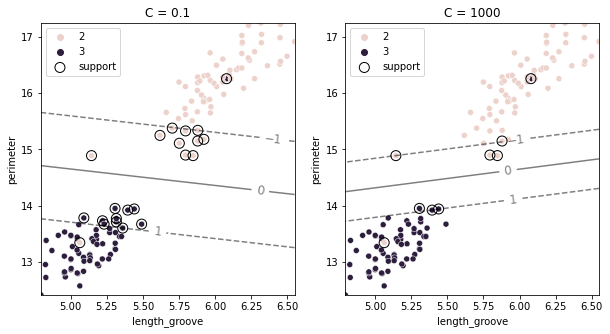

In [17]:
C_vals = [0.1, 1000]

fig, axes = plt.subplots(1,2, figsize=(10,5))
for ind, ax in enumerate(axes):
    
    clf_outlier = svm.SVC(kernel="linear", C=C_vals[ind])
    clf_outlier.fit(X_outlier, y_outlier);

    sns.scatterplot(data=seeds_outlier, x='length_groove', y='perimeter', hue='seed_type', ax=ax)

    Z_outlier = clf_outlier.decision_function(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

    # plot decision boundary and margins
    CS = ax.contour(
        X_1_grid, X_2_grid, Z_outlier, colors="k", levels=[-1, 0, 1], alpha=0.5,
        linestyles=["--", "-", "--"]
    )

    # plot support vectors
    ax.scatter(clf_outlier.support_vectors_[:, 0], clf_outlier.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');

    ax.clabel(CS, inline=1, fontsize=12)
    ax.set_title(f'C = {C_vals[ind]}')
    ax.legend();

## Non-linear SVM

When using SVM, one can go further than linear models and use a similar trick as for the extension of linear regression to non-linear models: adding features.  Such features can be e.g. polynomials ($\texttt{feature1}$ becomes $\texttt{feature1}^2$ or combinations of features e.g. the distance to a specific point in the dataset $feature1 - f_0$. These added features create a higher-dimensional dataset where we might be able to find a hyper-plane capable of creating clean categories. One simple example is the case of a dataset of two features with categories distributed in concentric ways:

In [115]:
data = np.random.randint(-50,51, (400,2))
cat = np.sqrt((data[:,0])**2+(data[:,1])**2)
cat = cat > 20
data = np.c_[data, cat]
data = pd.DataFrame(data, columns=['feature1', 'feature2', 'cat'])

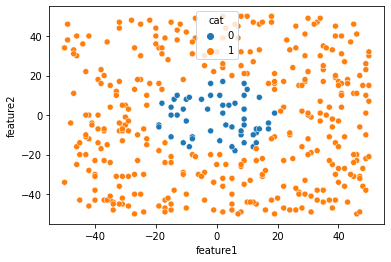

In [116]:
sns.scatterplot(data=data, x='feature1', y='feature2', hue='cat');

Here we can't find a hyper-plane, i.e. a line in this 2D plot, that would separate the two classes. However, if we can now consider an additional feature $\texttt{feature3} = \texttt{feature1}^2+\texttt{feature2}^2$:

In [117]:
data['feature3'] = data['feature1']**2 + data['feature2']**2

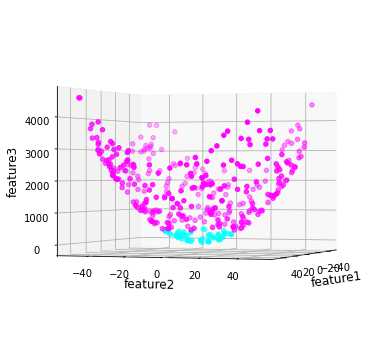

In [118]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)

scatter = ax.scatter(data['feature1'].values,
                     data['feature2'].values,
                     data['feature3'].values,
                     c=data['cat'].values, cmap='cool')
    

ax.set_xlabel('feature1', fontdict={'fontsize':12})
ax.set_ylabel('feature2', fontdict={'fontsize':12});
ax.set_zlabel('feature3', fontdict={'fontsize':12});
ax.view_init(elev=0., azim=20)
fig.tight_layout()

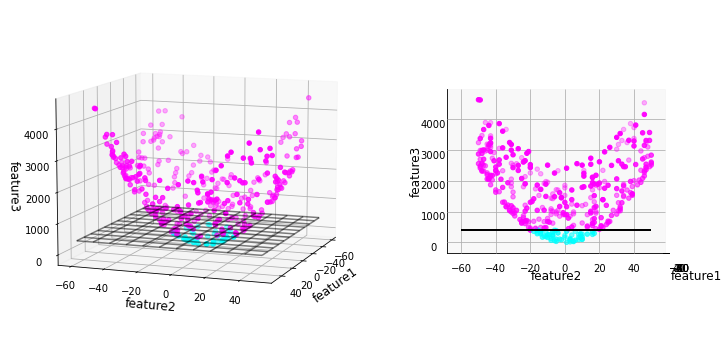

In [155]:
xgrid, ygrid = np.meshgrid(np.arange(-60,60,10), np.arange(-60,60,10))
zgrid = 400 * np.ones(xgrid.shape)

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d', computed_zorder=False)
ax2 = fig.add_subplot(1, 2, 2, projection='3d', computed_zorder=False)
axes = [ax1, ax2]
for ax in axes:
    scatter = ax.scatter(data['feature1'].values,
                         data['feature2'].values,
                         data['feature3'].values,
                         c=data['cat'].values, cmap='cool')

    ax.plot_wireframe(xgrid, ygrid, zgrid, alpha=0.5, color='black')

    ax.set_xlabel('feature1', fontdict={'fontsize':12})
    ax.set_ylabel('feature2', fontdict={'fontsize':12});
    ax.set_zlabel('feature3', fontdict={'fontsize':12});
    ax.view_init(elev=10., azim=20)
ax2.view_init(elev=-0, azim=0)
ax2.set_proj_type('ortho')

fig.tight_layout()

We see in the above plot that the magenta and cyan dots can now be separated by a plane (black) in this new space. 

Luckily, we don't have to add these new features manually. They are implemented using a trick (beyond the scope of this course) called the kernel trick. For example in the case above, we can try our luck with polynomial features of degree 4:

/Users/gw18g940/mambaforge/envs/EHML/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


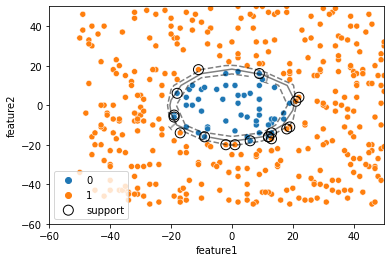

In [161]:
X = data[['feature1', 'feature2']]
y = data[['cat']]

clf_kernel = svm.SVC(kernel='poly', degree=4, C=1000)
clf_kernel.fit(X, y);

ax = sns.scatterplot(data=data, x='feature1', y='feature2', hue='cat')

xy = np.vstack([xgrid.ravel(), ygrid.ravel()]).T
Z = clf_kernel.decision_function(pd.DataFrame(xy, columns=['feature1', 'feature2'])).reshape(xgrid.shape)

# plot decision boundary and margins
CS = ax.contour(
    xgrid, ygrid, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(clf_kernel.support_vectors_[:, 0], clf_kernel.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

Of course this is a toy example, but the same kind of approach can be very effective at recovering complex patterns in datasets. For example if we looks at the seed types 1 and 3 now, we see that we have a few points of seed type 1 tend to "wrap around" type 3 on the lower left:

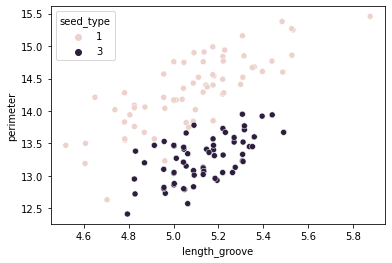

In [170]:
seeds_subsel = seeds[(seeds.seed_type == 1) | (seeds.seed_type == 3)]
sns.scatterplot(data=seeds_subsel, x='length_groove', y='perimeter', hue='seed_type');

This sort of behavior can be caught using SVM and a kernel:

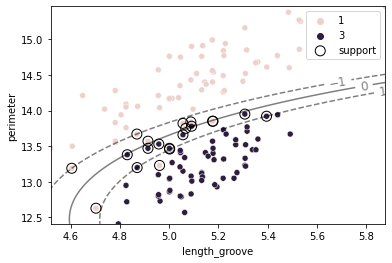

In [172]:
X = seeds_subsel[['length_groove', 'perimeter']]
y = seeds_subsel['seed_type']

clf_nonlin = svm.SVC(kernel='rbf', degree=8, C=1000)
clf_nonlin.fit(X, y);

xx = np.linspace(seeds_subsel.length_groove.min(), seeds_subsel.length_groove.max(), 1000)
yy = np.linspace(seeds_subsel.perimeter.min(), seeds_subsel.perimeter.max(),1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

ax = sns.scatterplot(data=seeds_subsel, x='length_groove', y='perimeter', hue='seed_type')

Z_nonlin = clf_nonlin.decision_function(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    XX, YY, Z_nonlin, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)

# plot support vectors
ax.scatter(clf_nonlin.support_vectors_[:, 0], clf_nonlin.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');

ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

## Multiple variables

Naturally, one can use the SVM model with more than two categories. Here we use all three, and none of the fit and prediction code changes:

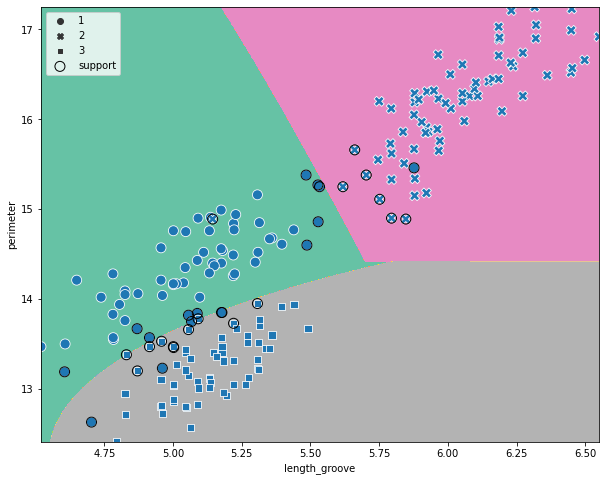

In [194]:
X = seeds[['length_groove', 'perimeter']]
y = seeds['seed_type']

clf_nonlin = svm.SVC(kernel='rbf', degree=8, C=1000)
clf_nonlin.fit(X, y);

xx = np.linspace(seeds.length_groove.min(), seeds.length_groove.max(), 1000)
yy = np.linspace(seeds.perimeter.min(), seeds.perimeter.max(),1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T


Z_nonlin = clf_nonlin.predict(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

fig, ax = plt.subplots(figsize=(10,8))
# plot decision boundary and margins
CS = ax.contourf(
    XX, YY, Z_nonlin, cmap='Set2'
)
sns.scatterplot(data=seeds, x='length_groove', y='perimeter', style='seed_type', s=100,
                ax=ax, palette='tab20')

# plot support vectors
ax.scatter(clf_nonlin.support_vectors_[:, 0], clf_nonlin.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.legend();

## Other algorithms: Nearest neighbors

In scikit-learn you can find even more algorithms for classification. There are also multiple variations of implementations e.g. for SVMs which are beyond the purpose of this course. We briefly here mention the nearest neighbor algorithm.

As the name says, the idea is here to check for any point in the feature space, how many points of each category are neighbors. Using the algorithm works in the same way as always:

In [195]:
from sklearn import neighbors

In [197]:
kn_model = neighbors.KNeighborsClassifier()
kn_model.fit(X=X, y=y);

And the prediction is done exactly as above on an array of values:

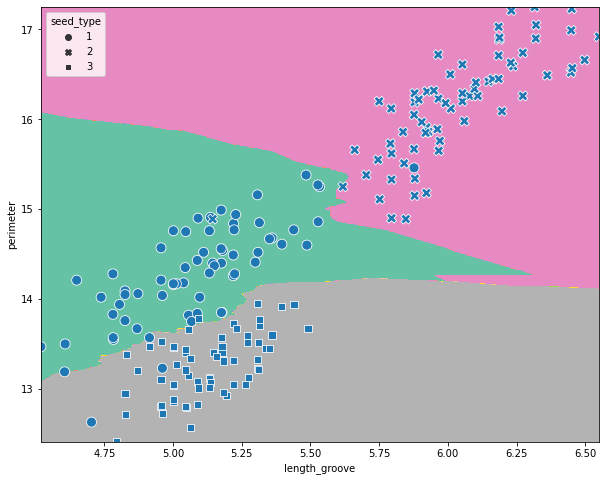

In [201]:
Z_kn = kn_model.predict(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

fig, ax = plt.subplots(figsize=(10,8))

CS = ax.contourf(
    XX, YY, Z_kn, cmap='Set2'
)
sns.scatterplot(data=seeds, x='length_groove', y='perimeter', style='seed_type', s=100,
                ax=ax, palette='tab20');

We see that the boundaries are not as regular as for example in the SVM case. This is natural, as no actual model is fitted here, the boundaries purely depend on the data. We can adjust the type of distances we measure, the algorithm etc. One of the most important parameters is the number of neighbors considered. By default its 5, but we can take a smaller number:

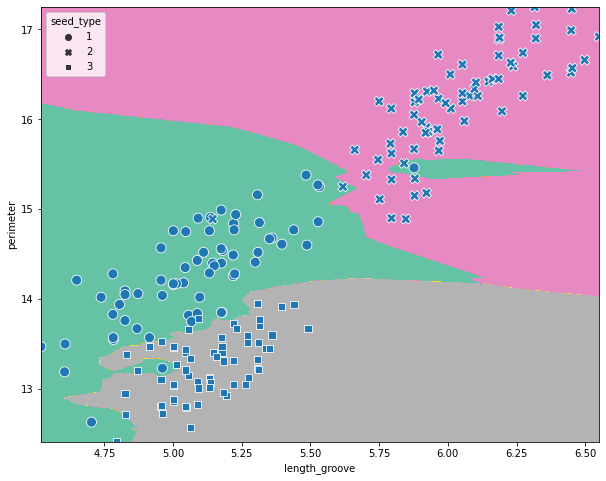

In [203]:
kn_model = neighbors.KNeighborsClassifier(n_neighbors=2)
kn_model.fit(X=X, y=y);

Z_kn = kn_model.predict(pd.DataFrame(xy, columns=['length_groove', 'perimeter'])).reshape(XX.shape)

fig, ax = plt.subplots(figsize=(10,8))

CS = ax.contourf(
    XX, YY, Z_kn, cmap='Set2'
)
sns.scatterplot(data=seeds, x='length_groove', y='perimeter', style='seed_type', s=100,
                ax=ax, palette='tab20');

We see that through this small number, outliers become more important. Depending on whether these outliers are meaningful (you might get such values again) or true outliers, this can be a positive or negative aspect.

In [ ]:
#